In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, simplify
import warnings

## Consider the $g$ that arises from the ode
$$
\dot{x} = \lambda +x - x^3
$$
namely, 

$$
f(x) = -x^2, \quad x \neq 0
$$

$$
g(x,\lambda) = \frac{1}{x} \left(\frac{\lambda}{x}+1\right)
$$

$$
\partial_x g(x,\lambda) = - \frac{1}{x^3}(2\lambda + x)
$$

# To do 
 - load data
 - load model
 - do contraction sweep
 - scaled data
 - create plots

In [2]:
def g_true(x,lam):
    return (1/x)*((lam / x) + 1)

def dgdx(x, lam):
    return -(1/ x**3) *(2 *lam+x)

def ode_rhs(x, lam):
    return lam+x-x**3

In [3]:
def contraction(x0, lam,iterations=100):
    try:
        # Explicitly catch RuntimeWarnings
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as exceptions

            g_vals = [x0]
            iters = 100
            xi = g_vals[0]
            for iter in range(iterations):
                xi = g_true(xi, lam)
                # print(xi)
                g_vals.append(xi)
            return True, g_vals

    except RuntimeWarning as e:
        # print("runtime", e)
        return False, False
    except Exception as e:
        # print("other",e)
        return False, False


In [4]:
from stabnode.node import set_global_seed
from data.hysteresis import simulate_steady_state
from sklearn.preprocessing import MinMaxScaler
import torch
device = 'cpu'
def load_data(seed, sample_rate):
    set_global_seed(seed = seed)
    
    lam_start = -1 
    lam_end = 1
    
    n_points = 250
    
    lam_increase = np.linspace(lam_start,lam_end, n_points)
    lam_decrease = np.linspace(lam_end, lam_start, n_points)
    
    x0=-1
    
    simulate_time = (0.,50.)
    
    x_increase = simulate_steady_state(lam_increase, x0, simulate_time,show_progress=True)
    x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time, show_progress=True)
    
    X = np.hstack((x_increase, x_decrease))
    lam = np.hstack((lam_increase, lam_decrease))
    repeat = 2
    
    for _ in range(repeat):
        X = np.hstack((X,X))
        lam = np.hstack((lam, lam))
    
    tau = torch.arange(0,len(lam),device=device)
    t = (tau+1)*simulate_time[-1]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
    
    # sample_rate = 10
    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    lam_train = lam[tau_train]

    def lam_func(tau):
        idx = int(tau) % len(lam)
        return torch.tensor(lam[idx],dtype=torch.float32, device=device)
    
    return X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func

In [35]:
sample_rate = 10
X, lam_vals, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func= load_data(1234,sample_rate)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [52]:
r2 = np.sqrt(4/27)
r1 = -r2

In [87]:
mask = lam_vals[:500] > r1
mask2 = lam_vals[:500] < r2
mask = mask & mask2
indicies = np.where(mask)[0]

In [132]:
print(np.where(indicies[1:] - indicies[:-1] > 1))
yes =np.where(indicies[1:] - indicies[:-1] > 1)[0][0]
indicies[:yes+1], indicies[yes+1:]

(array([95]),)


(array([ 77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172]),
 array([327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
        405, 406

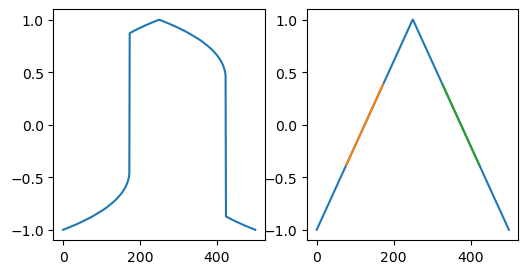

In [128]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.plot(X_scaled[:500])
ax2.plot(lam_vals[:500])
ax2.plot(indicies[:yes+1],lam_vals[indicies[:yes+1]])
ax2.plot(indicies[yes+1:],lam_vals[indicies[yes+1:]])
plt.show()

In [147]:
idx  =160 # 0 to 500
# idx = 577
# xi = torch.tensor(X_scaled[thing],dtype=torch.float32).reshape(-1,1)
xi = X_scaled[idx].reshape(-1,1)
xi_unscaled = X[idx]
lami = torch.tensor(lam_vals[idx],dtype=torch.float32).reshape(-1,1)

xi_unscaled,xi, lami, X.min(), X.max()

(-0.8031765766928332,
 tensor([[-0.6064]]),
 tensor([[0.2851]]),
 -1.3245502123805168,
 1.3244391475471649)

In [164]:
xs = np.linspace(X.max()+1, X.min()-1,251)
threshold = 0.1 # Define a threshold, e.g., anything between -0.5 and 0.5 will be zero

out = np.abs(dgdx(xs, lami.detach().numpy()[0,0]))
mask1 = out < 1
mask2 = out > 0
mask = mask1 & mask2
mappings = []
xvals = []
for x0 in xs:
    flag, g_vals = contraction(x0, lam=lami.detach().numpy()[0,0])
    if flag:
        xvals.append(x0)
        mappings.append(g_vals)

xvals = np.array(xvals)
mappings = np.array(mappings)
xvals_scaled = scaler.transform(xvals.reshape(-1,1)).reshape(-1)

In [165]:
xvals

array([-0.33478277, -0.35337872, -0.37197468, -0.39057064, -0.4091666 ,
       -0.42776255, -0.44635851, -0.46495447, -0.48355043, -0.50214638,
       -0.52074234, -0.5393383 , -0.55793426, -0.57653021, -0.59512617,
       -0.61372213, -0.63231809, -0.65091404, -0.66951   , -0.68810596,
       -0.70670192, -0.72529787, -0.74389383, -0.76248979, -0.78108574,
       -0.7996817 , -0.81827766, -0.83687362, -0.85546957, -0.87406553,
       -0.89266149, -0.91125745, -0.9298534 , -0.94844936, -0.96704532,
       -0.98564128, -1.00423723, -1.02283319, -1.04142915, -1.06002511,
       -1.07862106, -1.09721702, -1.11581298, -1.13440894, -1.15300489,
       -1.17160085, -1.19019681, -1.20879277, -1.22738872, -1.24598468,
       -1.26458064, -1.2831766 , -1.30177255, -1.32036851, -1.33896447,
       -1.35756043, -1.37615638, -1.39475234, -1.4133483 , -1.43194426,
       -1.45054021, -1.46913617, -1.48773213, -1.50632809, -1.52492404,
       -1.54352   , -1.56211596, -1.58071191, -1.59930787, -1.61

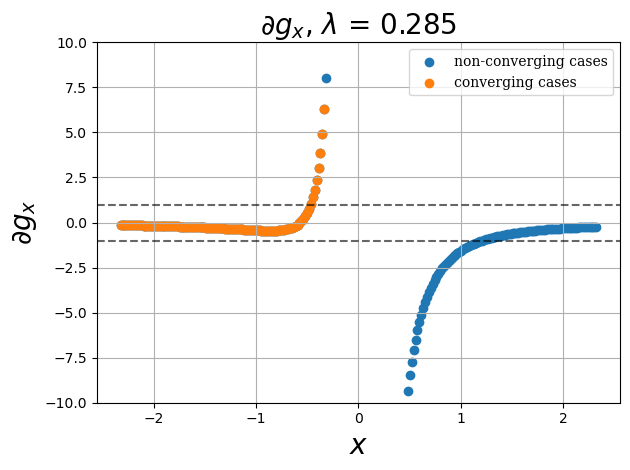

In [173]:
plt.axhline(1, linestyle='--', color="black", alpha=0.6)
# plt.axhline(0)
plt.axhline(-1,linestyle='--', color="black", alpha=0.6)
plt.scatter(xs, dgdx(xs, lami.detach().numpy()), label="non-converging cases")
# plt.scatter(xs[mask], dgdx(xs[mask], lami.detach().numpy()))
plt.scatter(np.array(xvals), dgdx(np.array(xvals), lami.detach().numpy()), label="converging cases")
plt.xlabel(r"$x$",size=20)
plt.ylabel(r"$\partial g_x$", size=20)
plt.grid(True)
plt.title(rf"$\partial g_x$, $\lambda$ = {lami.detach().numpy()[0,0]:.3f}", size=20)
plt.ylim(-10,10)
plt.legend(prop={"family": 'serif'})
plt.tight_layout()
plt.savefig(f"partial_g_lam_{lami.detach().numpy()[0,0]:.3f}.png")
plt.show()

In [151]:
from stabnode.node import _load_model_opt
import torch
path = "../results/july_17/seed_1234_sample_rate_10_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt"

model, opt, epoch, loss = _load_model_opt(path)

In [152]:
g = model.g

g.eval()

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [153]:
# xi = torch.tensor(xvals_scaled[10],dtype=torch.float32).reshape(-1,1)
xi

tensor([[-0.6064]])

In [154]:
new_mappings = []
for xis in xvals_scaled:
    xis = torch.tensor(xis,dtype=torch.float32).reshape(-1,1)
    gvals = [xis.detach().numpy()[0,0]]
    for _ in range(100):
        with torch.no_grad():
            xis = g(xis,lami)
            gvals.append(xis.detach().numpy()[0,0])
    new_mappings.append(gvals)
new_mappings = np.array(new_mappings)

In [155]:
unscaled_new_maps = []
for new_map in new_mappings:
    unscaled_new_maps.append(scaler.inverse_transform(new_map.reshape(-1,1)).reshape(-1))

In [156]:
# new_mappings = np.array(new_mappings)
# for map_idx in range(0, len(new_mappings),10):
#     plt.plot(unscaled_new_maps[map_idx][:20])
# plt.axhline(xi_unscaled, linestyle='--',c='black',alpha=0.65, label = "expected steady state")
# plt.grid(True)
# plt.show()

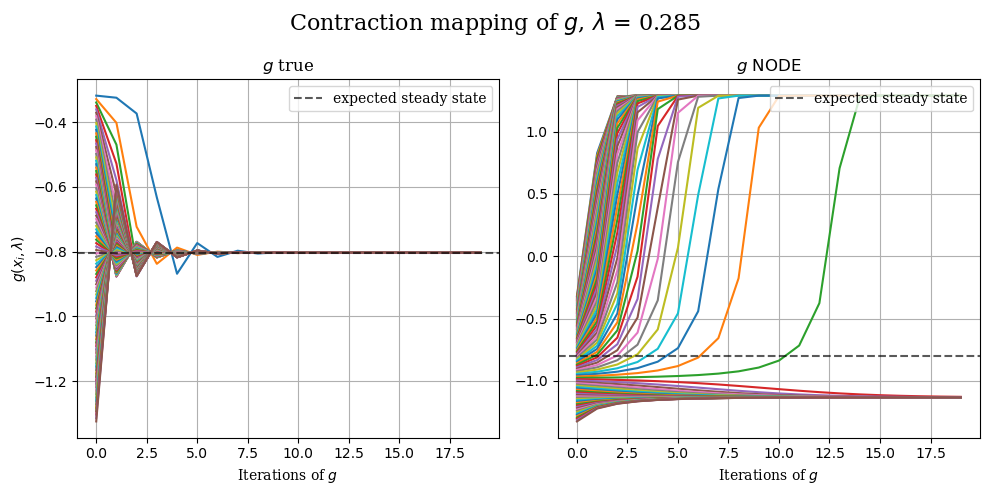

In [157]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

rate = 1
cutoff = 20

for which_mapping in range(0,len(mappings),rate):
    # plt.plot(mappings[which_mapping][:cutoff],label = rf"$x_0$ = {xvals[which_mapping]:.3f}," )
    ax1.plot(mappings[which_mapping][:cutoff], )
# ax1.set_title(rf" $\lambda$ = {lami.detach().numpy()[0,0]:.3f}",family='serif')
ax1.axhline(xi_unscaled, linestyle='--',c='black',alpha=0.65, label = "expected steady state")
ax1.legend(prop = {"family":"serif"},loc = 'upper right')
ax1.set_xlabel(r"Iterations of $g$ ", family = 'serif')
ax1.set_ylabel(r"$g(x_i, \lambda)$", family='serif')
ax1.grid(True)
ax1.set_title(r"$g$ true", family = 'serif')

for map_idx in range(0, len(unscaled_new_maps),rate):
    ax2.plot(unscaled_new_maps[map_idx][:20])
ax2.axhline(xi_unscaled, linestyle='--',c='black',alpha=0.65, label = "expected steady state")
ax2.set_xlabel(r"Iterations of $g$ ", family = 'serif')
ax2.legend(prop = {"family":"serif"},loc = 'upper right')
ax2.grid(True)
ax2.set_title(r"$g$ NODE")

plt.suptitle(rf"Contraction mapping of $g$, $\lambda$ = {lami.detach().numpy()[0,0]:.3f}", family='serif',size=16)
plt.tight_layout()
plt.savefig(f"contraction_g_sample_rate_{sample_rate}_lam_{lami.detach().numpy()[0,0]:.3f}.png")
plt.show()

In [158]:
scaler.transform(xvals.reshape(-1,1)).reshape(-1)

array([-0.24 , -0.248, -0.256, -0.264, -0.272, -0.28 , -0.288, -0.296,
       -0.304, -0.312, -0.32 , -0.328, -0.336, -0.344, -0.352, -0.36 ,
       -0.368, -0.376, -0.384, -0.392, -0.4  , -0.408, -0.416, -0.424,
       -0.432, -0.44 , -0.448, -0.456, -0.464, -0.472, -0.48 , -0.488,
       -0.496, -0.504, -0.512, -0.52 , -0.528, -0.536, -0.544, -0.552,
       -0.56 , -0.568, -0.576, -0.584, -0.592, -0.6  , -0.608, -0.616,
       -0.624, -0.632, -0.64 , -0.648, -0.656, -0.664, -0.672, -0.68 ,
       -0.688, -0.696, -0.704, -0.712, -0.72 , -0.728, -0.736, -0.744,
       -0.752, -0.76 , -0.768, -0.776, -0.784, -0.792, -0.8  , -0.808,
       -0.816, -0.824, -0.832, -0.84 , -0.848, -0.856, -0.864, -0.872,
       -0.88 , -0.888, -0.896, -0.904, -0.912, -0.92 , -0.928, -0.936,
       -0.944, -0.952, -0.96 , -0.968, -0.976, -0.984, -0.992, -1.   ])

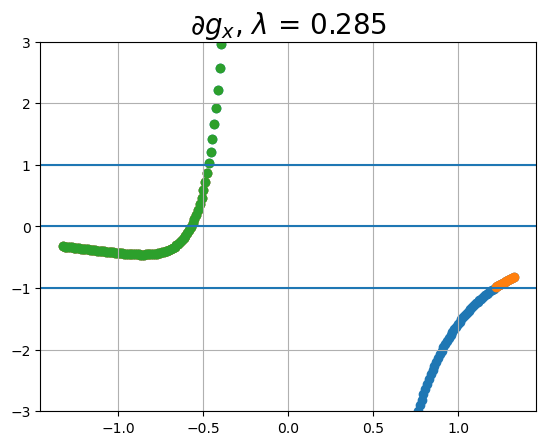

In [20]:
plt.axhline(1)
plt.axhline(0)
plt.axhline(-1)
plt.scatter(xs, dgdx(xs, lami.detach().numpy()))
plt.scatter(xs[mask], dgdx(xs[mask], lami.detach().numpy()))
plt.scatter(np.array(xvals), dgdx(np.array(xvals), lami.detach().numpy()))
plt.grid(True)
plt.title(rf"$\partial g_x$, $\lambda$ = {lami.detach().numpy()[0,0]:.3f}", size=20)
plt.ylim(-3,3)
plt.show()

In [ ]:
coeff_func = lambda lam: [-1,0,1,2*lam]

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

real_roots(coeff_func(lam))


In [ ]:
def descrim(lam):
    a = -1
    b = 0
    c = 1
    d = lam
    p = (3*a*c-b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

    return - (4*p**3 + 27*q**2)
    

In [ ]:
lam = symbols('lam')

a = -1
b = 0
c = 1
d = lam
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = -  (4*p**3 + 27*q**2)
D = simplify(D)

solve(Eq(D,0), lam)
lam1, lam2 = -np.sqrt(4/27), np.sqrt(4/27)

In [ ]:
lam_vals = np.linspace(lam1-0.2, lam2+0.2, 51)

lam_neg = np.linspace(lam1-0.2, lam1, 51)
lam_pos = np.linspace(lam1, lam2, 51)
lam_neg2 = np.linspace(lam2, lam2+0.2,51)

plt.plot(lam_neg, descrim(lam_neg), color='black')
plt.plot(lam_pos, descrim(lam_pos), color='red', linestyle='--')
plt.plot(lam_neg2, descrim(lam_neg2),color='black')
plt.title("Descrimant", family='serif')
plt.xlabel(r"$\lambda$")
plt.grid(True)
plt.show()

## Bifurcation plots

In [ ]:
def ode_coeff(lam):
    a = -1
    b = 0
    c = 1
    d = lam
    return [a,b,c,d]

def real_roots(coeffs):
    roots = np.roots(coeffs)
    return sorted([r.real for r in roots if np.isreal(r)])

In [ ]:
lam = np.sqrt(4/27)-0.001
lam= 0.28
roots = real_roots(ode_coeff(lam))
print(roots)
xs = np.linspace(-1.5,1.5,51)
plt.plot(xs, ode_rhs(xs,lam))
plt.axvline(roots[0], color='black',linestyle='--', alpha=0.5, label=f"stable: x = {roots[0]:.3f}")
if len(roots) == 3:
    plt.axvline(roots[1], color='red', linestyle="--", alpha=0.5, label=f"unstable: x={roots[1]:.3f}")
    plt.axvline(roots[2], color='black',linestyle='--', alpha=0.5, label = f"stable: x={roots[2]:.3f}")
plt.axhline(0,color='black', linestyle="--", alpha=0.5)
plt.xlabel("x")
plt.ylabel("dx")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_point = np.sqrt(4/27)+0.1
end_point = 2
lam_up = np.linspace(-2, end_point, 200)
lam_down = np.linspace(end_point, -2, 200)
lam_vals = np.hstack((lam_up,lam_down))
def lam_func(idx):
    idx = idx % len(lam_vals)
    return lam_vals[idx]

In [ ]:
# plt.plot(lam_func(np.arange(800)))

In [ ]:
lam= np.sqrt(4/27)
lam = 0.28

In [ ]:
x0 = -1
# x0 =-0.5
x0 = 0.5
# x0 = 1.5
# x0=2

In [ ]:
import warnings

success = []
for x0 in xs[mask]:
    try:
        # Explicitly catch RuntimeWarnings
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)  # Treat RuntimeWarnings as exceptions

            g_vals = [x0]
            iters = 100
            xi = g_vals[0]
            for iter in range(iters):
                xi = g_true(xi, lam)
                g_vals.append(xi)

        success.append(True)  # If no warning occurs, append success
    except RuntimeWarning as e:
        success.append(False)  # If a RuntimeWarning occurs, append failure
    except Exception as e:
        success.append(False)  # Handle other exceptions


In [ ]:
plt.plot(success)

In [ ]:
success = []
for x0 in xs:
    try: 
        g_vals = [x0]
        iters = 100
        xi = g_vals[0]
        for iter in range(iters):
            xi = g_true(xi,lam)
            g_vals.append(xi)
        success.append(True)
    except Exception as e:
        sucess.append(False)
        

In [ ]:
success

In [ ]:
plt.plot(g_vals)

In [ ]:
g_vals